# Fetching SDSS images for source classification

This notebook

- makes an SQL query to the SDSS DR12 database (using its [API](http://skyserver.sdss.org/dr12/en/help/docs/api.aspx)) to create a catalog, 
- downloads the FITS files,
- uses [Montage](http://montage.ipac.caltech.edu/) (and [montage wrapper](http://www.astropy.org/montage-wrapper/) to align each image to the image in the $r$-band, and
- uses [Sextractor](http://www.astromatic.net/software/sextractor) to find the pixel position of objects, and
- converts the fluxes in FITS files to [luptitudes](http://www.sdss.org/dr12/algorithms/magnitudes/#asinh).

This [Docker image](https://github.com/EdwardJKim/deeplearning4astro/tree/master/docker) has all packages necessary to run this notebook.

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import shutil
import requests
import json
import bz2
import re
import subprocess
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import montage_wrapper as mw
from astropy.io import fits
from astropy import wcs

## SQL

For demonstration purposes, we use the SDSS [API](http://skyserver.sdss.org/dr12/en/help/docs/api.aspx) to create an SQL query. However, it's not suitable for making a query with a large number of objects, so the following functions uses only a 1 sq. deg. patch of sky.

[SpecObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecObjAll+U)

[PhotoObjAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U)

Although there exists a precomputed join ([SpecPhotoAll](http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecPhotoAll+U)) between the PhotoOjbAll and SpecObjAll tables, we do a join ourselves because SpecPhotoAll doesn't have some attributes we want, e.g. the clean photometry flag or the light profiles ("expRad" and "deVRad").

In [3]:
def sample_one_sq_deg(ra, dec, n=500, dr="dr12", timeout=60):
    
    url = "http://skyserver.sdss.org/{}/en/tools/search/x_sql.aspx".format(dr)
    payload = {
        "format": "json",
        "cmd": """
            SELECT TOP {0} spec.specObjID, phot.objID,
                spec.ra, spec.dec,
                spec.class,
                spec.z, spec.zErr,
                phot.rerun, phot.run, phot.camcol, phot.field,
                phot.dered_u, phot.dered_g, phot.dered_r, phot.dered_i, phot.dered_z,
                phot.extinction_u, phot.extinction_g, phot.extinction_r, phot.extinction_i, phot.extinction_z
            FROM SpecObjAll AS spec
            JOIN PhotoObjAll AS phot
            ON spec.specObjID = phot.specObjID
            WHERE
                phot.clean = 1
                AND spec.zWarning = 0
                AND spec.ra >= {1}
                AND spec.ra < {2}
                AND spec.dec >= {3}
                AND spec.dec < {4}
                AND phot.dered_r > 0 and phot.dered_r < 40
                AND phot.expRad_r < 30
                AND phot.deVRad_r < 30
                AND spec.zErr < 0.1
                AND spec.z < 2
            ORDER BY NEWID()
        """.format(n, ra, ra + 1, dec, dec + 1).strip()
    }
    
    try:
        resp = requests.post(url, params=payload, timeout=timeout)
    except requests.exceptions.RequestException as e:
        print(e)
        return None

    data = resp.json()[0]['Rows']
    
    df = pd.DataFrame(data)
    
    df[["specObjID", "objID"]] = df[["specObjID", "objID"]].astype("object")

    return df

For a large number of objects, you can use [CasJobs](http://skyserver.sdss.org/casjobs) as follows.

```sql
SELECT spec.specObjID, phot.objID,
    spec.ra, spec.dec,
    spec.class,
    spec.z, spec.zErr,
    phot.rerun, phot.run, phot.camcol, phot.field,
    phot.dered_u, phot.dered_g, phot.dered_r, phot.dered_i, phot.dered_z,
    phot.psfMag_u, phot.psfMag_g, phot.psfMag_r, phot.psfMag_i, phot.psfMag_z,
    cModelMag_u, cModelMag_g, cModelMag_r, cModelMag_i, cModelMag_z
INTO mydb.DR12_spec_phot_all
FROM SpecObjAll AS spec
JOIN PhotoObjAll AS phot
ON spec.specObjID = phot.specObjID
WHERE
    phot.clean = 1
    AND spec.zWarning = 0
    AND phot.dered_r > 0 and phot.dered_r < 40
    AND phot.expRad_r < 30
    AND phot.deVRad_r < 30
    AND spec.zErr < 0.1
    AND spec.z < 2
```

From this table `mydb.DR12_spec_phot_all`, we randomly choose 100,000 objects:

```sql
SELECT TOP 100000 *
INTO mydb.DR12_spec_phot_sample
FROM mydb.DR12_spec_phot_all
ORDER BY NEWID()
```

In [4]:
df = sample_one_sq_deg(170, 0)

df.to_csv("objects.csv", index=False)

print(df)

     camcol   class       dec   dered_g   dered_i   dered_r   dered_u  \
0         6  GALAXY  0.844954  17.68666  16.67552  17.03090  19.14561   
1         6  GALAXY  0.989133  18.61307  17.17333  17.56812  20.67681   
2         5  GALAXY  0.424741  16.92084  16.13760  16.40871  18.24213   
3         4  GALAXY  0.311179  18.28219  17.10295  17.49564  19.69760   
4         6  GALAXY  0.935754  18.70298  18.15948  18.39456  19.76915   
5         4  GALAXY  0.320944  21.14234  19.05719  19.81964  22.11666   
6         4  GALAXY  0.034847  21.98429  19.55827  20.33576  22.44582   
7         5  GALAXY  0.568991  22.74249  19.99565  21.17503  24.08202   
8         5  GALAXY  0.784276  16.56332  15.17607  15.57846  18.58672   
9         4    STAR  0.279292  17.96272  17.61458  17.71525  18.81065   
10        5  GALAXY  0.616381  18.51592  17.11884  17.60036  20.37709   
11        5  GALAXY  0.520416  17.82985  16.69597  17.11121  19.32697   
12        5  GALAXY  0.572814  22.38918  19.73572  

## FITS images

Images and derived catalog data are described on the imaging data page. You can use a SkyServer search or the file window_flist.fits file to identify which RERUN-RUN-CAMCOL-FIELD overlaps your region of interest. Then download the matching calibObj files (catalog data) or frame files (calibrated imaging data), e.g., for RERUN 301, RUN 2505, CAMCOL 3, FIELD 38, the r-band image is:

```shell
$ wget --spider http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/2505/3/frame-r-002505-3-0038.fits.bz2
```

In [5]:
def fetch_fits(df, dirname="temp"):

    bands = [c for c in 'ugriz']

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    for i, r in df.iterrows():

        url = "http://data.sdss3.org/sas/dr12/boss/photoObj/frames/{0}/{1}/{2}/".format(
            r["rerun"], r["run"], r["camcol"], r["field"])

        print("Downloading rerun: {}, run: {}, camcol: {}, field:{}".format(
            r["rerun"], r["run"], r["camcol"], r["field"]))
    
        for band in bands:

            filename = "frame-{4}-{1:06d}-{2}-{3:04d}.fits".format(
                r["rerun"], r["run"], r["camcol"], r["field"], band)
            filepath = os.path.join(dirname, filename)
            
            if os.path.exists(filepath):
                continue

            for _ in range(10):
                try:
                    resp = requests.get(url + filename + ".bz2")
                except:
                    sleep(1)
                    continue
                
                if resp.status_code == 200:
                    with open(filepath, "wb") as f:
                        img = bz2.decompress(resp.content)
                        f.write(img)
                    break
                else:
                    sleep(1)
                    continue

            if not os.path.exists(filepath):
                raise Exception

In [6]:
fetch_fits(df)

In [7]:
def get_ref_list(df):

    ref_images = []
    
    for row in df.iterrows():
        r = row[1]
        filename = "frame-r-{1:06d}-{2}-{3:04d}.fits".format(r["rerun"], r["run"], r["camcol"], r["field"])
        ref_images.append(filename)

    return ref_images

ref_images = get_ref_list(df)

## Montage

### Converting ra and dec values to pixel positions

[re-projection](http://montage.ipac.caltech.edu/docs/algorithms.html)

Montage sometimes throws the following error:

```
MontageError: mProject: File (/notebooks/shared/images/raw/frame-z-007712-3-0338.fits) is not a FITS image
```

When this happens, deleting the offending file and rerunning `fetch_fits()` fixes the error.

In [8]:
def align_images(images, frame_dir="temp", registered_dir="temp"):

    if not os.path.exists(registered_dir):
        os.makedirs(registered_dir)
    
    for image in images:

        registered_path = [
            os.path.join(registered_dir, image.replace("frame-r-", "registered-{}-").format(b))
            for b in "ugriz"
            ]
        
        if all([os.path.exists(r) for r in registered_path]):
            print("Skipping {}...".format(image))
            continue
        else:
            print("Processing {}...".format(image))
    
        frame_path = [
            os.path.join(frame_dir, image.replace("frame-r-", "frame-{}-").format(b))
            for b in "ugriz"
            ]

        header = os.path.join(
            registered_dir,
            image.replace("frame", "header").replace(".fits", ".hdr")
            )

        mw.commands.mGetHdr(os.path.join(frame_dir, image), header)
        mw.reproject(
            frame_path, registered_path,
            header=header, exact_size=True, silent_cleanup=True, common=True
            )

    return None

In [9]:
align_images(ref_images)

Skipping frame-r-006793-6-0067.fits...
Skipping frame-r-006793-6-0069.fits...
Skipping frame-r-006793-5-0067.fits...
Skipping frame-r-000756-4-0364.fits...
Skipping frame-r-006793-6-0069.fits...
Skipping frame-r-000756-4-0364.fits...
Skipping frame-r-006793-4-0065.fits...
Skipping frame-r-006793-5-0064.fits...
Skipping frame-r-000756-5-0365.fits...
Skipping frame-r-000756-4-0368.fits...
Skipping frame-r-006793-5-0067.fits...
Skipping frame-r-006793-5-0064.fits...
Skipping frame-r-006793-5-0064.fits...
Skipping frame-r-006793-6-0066.fits...
Skipping frame-r-006793-5-0067.fits...
Skipping frame-r-000756-5-0365.fits...
Skipping frame-r-006793-5-0068.fits...
Skipping frame-r-000756-4-0363.fits...
Skipping frame-r-006793-4-0065.fits...
Skipping frame-r-006793-4-0069.fits...
Skipping frame-r-006793-6-0068.fits...
Skipping frame-r-006793-4-0069.fits...
Skipping frame-r-006793-5-0067.fits...
Skipping frame-r-000756-5-0368.fits...
Skipping frame-r-000756-5-0366.fits...
Skipping frame-r-006793-5

In [10]:
def convert_catalog_to_pixels(df, dirname="temp"):

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    pixels = []
    fits_list = []

    for i, r in df.iterrows():

        fits_file = "registered-r-{1:06d}-{2}-{3:04d}.fits".format(
            r["rerun"], r["run"], r["camcol"], r["field"])
        fits_path = os.path.join(dirname, fits_file)
            
        hdulist = fits.open(fits_path)

        w = wcs.WCS(hdulist[0].header, relax=False)
        
        px, py = w.all_world2pix(r["ra"], r["dec"], 1)

        fits_list.append(fits_file)
        pixels.append((i, px, py, r["class"]))

    for i, fits_file in enumerate(fits_list):
        ix, px, py, c = pixels[i]
        pixel_list = fits_file.replace(".fits", ".list")
        pixel_path = os.path.join(dirname, pixel_list)
        with open(pixel_path, "a") as fout:
            fout.write("{} {} {} {}\n".format(ix, px, py, c))

    return None

In [11]:
convert_catalog_to_pixels(df)

RADECSYS is non-standard, use RADESYSa. [astropy.wcs.wcs]
RADECSYS is non-standard, use RADESYSa.


## Sextractor

In [12]:
%%writefile default.conv
CONV NORM
# 3x3 ``all-ground'' convolution mask with FWHM = 2 pixels.
1 2 1
2 4 2
1 2 1

Overwriting default.conv


In [13]:
%%writefile default.param
XMIN_IMAGE               Minimum x-coordinate among detected pixels                [pixel]
YMIN_IMAGE               Minimum y-coordinate among detected pixels                [pixel]
XMAX_IMAGE               Maximum x-coordinate among detected pixels                [pixel]
YMAX_IMAGE               Maximum y-coordinate among detected pixels                [pixel]
VECTOR_ASSOC(1)          #ASSOCiated parameter vector

Overwriting default.param


In [14]:
%%writefile default.sex
#-------------------------------- Catalog ------------------------------------
 
CATALOG_NAME     test.cat       # name of the output catalog
CATALOG_TYPE     ASCII_HEAD     # NONE,ASCII,ASCII_HEAD, ASCII_SKYCAT,
                                # ASCII_VOTABLE, FITS_1.0 or FITS_LDAC
PARAMETERS_NAME  default.param  # name of the file containing catalog contents
 
#------------------------------- Extraction ----------------------------------
 
DETECT_TYPE      CCD            # CCD (linear) or PHOTO (with gamma correction)
DETECT_MINAREA   3              # min. # of pixels above threshold
DETECT_THRESH    1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2
ANALYSIS_THRESH  1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2
 
FILTER           Y              # apply filter for detection (Y or N)?
FILTER_NAME      default.conv   # name of the file containing the filter
 
DEBLEND_NTHRESH  32             # Number of deblending sub-thresholds
DEBLEND_MINCONT  0.005          # Minimum contrast parameter for deblending
 
CLEAN            Y              # Clean spurious detections? (Y or N)?
CLEAN_PARAM      1.0            # Cleaning efficiency
 
MASK_TYPE        CORRECT        # type of detection MASKing: can be one of
                                # NONE, BLANK or CORRECT

#------------------------------ Photometry -----------------------------------
 
PHOT_APERTURES   5              # MAG_APER aperture diameter(s) in pixels
PHOT_AUTOPARAMS  2.5, 3.5       # MAG_AUTO parameters: <Kron_fact>,<min_radius>
PHOT_PETROPARAMS 2.0, 3.5       # MAG_PETRO parameters: <Petrosian_fact>,
                                # <min_radius>

SATUR_LEVEL      50000.0        # level (in ADUs) at which arises saturation
SATUR_KEY        SATURATE       # keyword for saturation level (in ADUs)
 
MAG_ZEROPOINT    0.0            # magnitude zero-point
MAG_GAMMA        4.0            # gamma of emulsion (for photographic scans)
GAIN             0.0            # detector gain in e-/ADU
GAIN_KEY         GAIN           # keyword for detector gain in e-/ADU
PIXEL_SCALE      1.0            # size of pixel in arcsec (0=use FITS WCS info)
 
#------------------------- Star/Galaxy Separation ----------------------------
 
SEEING_FWHM      1.2            # stellar FWHM in arcsec
STARNNW_NAME     default.nnw    # Neural-Network_Weight table filename
 
#------------------------------ Background -----------------------------------
 
BACK_SIZE        64             # Background mesh: <size> or <width>,<height>
BACK_FILTERSIZE  3              # Background filter: <size> or <width>,<height>
 
BACKPHOTO_TYPE   GLOBAL         # can be GLOBAL or LOCAL
 
#------------------------------ Check Image ----------------------------------
 
CHECKIMAGE_TYPE  SEGMENTATION   # can be NONE, BACKGROUND, BACKGROUND_RMS,
                                # MINIBACKGROUND, MINIBACK_RMS, -BACKGROUND,
                                # FILTERED, OBJECTS, -OBJECTS, SEGMENTATION,
                                # or APERTURES
CHECKIMAGE_NAME  check.fits     # Filename for the check-image
 
#--------------------- Memory (change with caution!) -------------------------
 
MEMORY_OBJSTACK  3000           # number of objects in stack
MEMORY_PIXSTACK  300000         # number of pixels in stack
MEMORY_BUFSIZE   1024           # number of lines in buffer
 
#----------------------------- Miscellaneous ---------------------------------
 
VERBOSE_TYPE     NORMAL         # can be QUIET, NORMAL or FULL
HEADER_SUFFIX    .head          # Filename extension for additional headers
WRITE_XML        N              # Write XML file (Y/N)?
XML_NAME         sex.xml        # Filename for XML output

#----------------------------- ASSOC parameters ---------------------------------

ASSOC_NAME       sky.list       # name of the ASCII file to ASSOCiate, the expected pixel 
                                # coordinates list given as [id, xpos, ypos]
ASSOC_DATA       1              # columns of the data to replicate (0=all), replicate id
                                # of the object in the SExtractor output file
ASSOC_PARAMS     2,3            # columns of xpos,ypos[,mag] in the expected pixel
                                # coordinates list
ASSOC_RADIUS     2.0            # cross-matching radius (pixels)
ASSOC_TYPE       NEAREST        # ASSOCiation method: FIRST, NEAREST, MEAN,
                                # MAG_MEAN, SUM, MAG_SUM, MIN or MAX
ASSOCSELEC_TYPE  MATCHED        # ASSOC selection type: ALL, MATCHED or -MATCHED

Overwriting default.sex


In [15]:
def run_sex(df, dirname="temp"):
    """
    """

    cat = pd.DataFrame()

    ref_images = get_ref_list(df) 
    registered_all = [f.replace("frame-", "registered-") for f in ref_images]
    
    for f in registered_all:
        
        fpath = os.path.join(dirname, f)
        
        list_file = f.replace(".fits", ".list")
        list_path = os.path.join(dirname, list_file)

        config_file = f.replace(".fits", ".sex")

        with open("default.sex", "r") as default:
            with open(config_file, "w") as temp:
                for line in default:
                    line = re.sub(
                        r"^ASSOC_NAME\s+sky.list",
                        "ASSOC_NAME       {}".format(list_file),
                        line
                    )
                    temp.write(line)
    
        shutil.copy(list_path, os.getcwd())
    
        subprocess.call(["sex", "-c", config_file, fpath])

        os.remove(config_file)
    
        try:
            assoc = pd.read_csv(
                "test.cat",
                skiprows=5,
                sep="\s+",
                names=["xmin", "ymin", "xmax", "ymax", "match"]
            )
            assoc["file"] = f
            cat = cat.append(assoc)
        except:
            pass
        
        os.remove(os.path.join(os.getcwd(), list_file))
    
    if len(cat) > 0:
        cat["class"] = df.ix[cat["match"], "class"].values
        cat["objID"] = df.ix[cat["match"], "objID"].values
        
    #cat = cat.reset_index(drop=True)

    return cat

In [16]:
cat = run_sex(df)

## Converting fluxes to magnitudes

In [17]:
def nanomaggie_to_luptitude(array, band):
    '''
    Converts nanomaggies (flux) to luptitudes (magnitude).

    http://www.sdss.org/dr12/algorithms/magnitudes/#asinh
    http://arxiv.org/abs/astro-ph/9903081
    '''
    b = {
        'u': 1.4e-10,
        'g': 0.9e-10,
        'r': 1.2e-10,
        'i': 1.8e-10,
        'z': 7.4e-10
    }
    nanomaggie = array * 1.0e-9 # fluxes are in nanomaggies

    luptitude = -2.5 / np.log(10) * (np.arcsinh((nanomaggie / (2 * b[band]))) + np.log(b[band]))
    
    return luptitude

## Creating cutout images

In [18]:
def save_cutout(df, cat, size=48, image_dir="temp", save_dir="result"):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    saved = pd.DataFrame()

    def find_position(xmin, xmax, cut_size, frame_size):
        diff = 0.5 * ((xmax - xmin) - cut_size)
        if xmin + diff < 0:
            r = 0
            l = r + cut_size
        elif xmax + diff >= frame_size:
            l = frame_size
            r = l - cut_size
        else:
            r = int(xmin + diff)
            l = r + cut_size
        return r, l

    for i, row in cat.iterrows():

        array = np.zeros((5, size, size))
        
        y0, x0, y1, x1 = row[["xmin", "ymin", "xmax", "ymax"]].values
        matched = df[df["objID"] == row.astype("object")["objID"]]
        assert len(matched) == 1

        for j, b in enumerate("ugriz"):

            fpath = os.path.join(image_dir, row["file"])
            image_data = fits.getdata(fpath.replace("-r-", "-{}-".format(b)))
            
            extinction = matched["extinction_{}".format(b)].values[0]

            right, left = find_position(x0, x1, size, image_data.shape[0])
            down, up = find_position(y0, y1, size, image_data.shape[1])

            cut_out = image_data[right: left, down: up]
        
            if cut_out.shape[0] == size and cut_out.shape[1] == size:
                cut_out = nanomaggie_to_luptitude(cut_out, b) - extinction
                array[j, :, :] = cut_out
                
        if np.isnan(array).sum() == 0 and array.sum() > 0:
            save_path = os.path.join(save_dir, "{0}.{1}x{1}.{2}.npy".format(row["class"], size, row["objID"]))
            np.save(save_path, array)

In [19]:
save_cutout(df, cat, size=48)

## Sample images

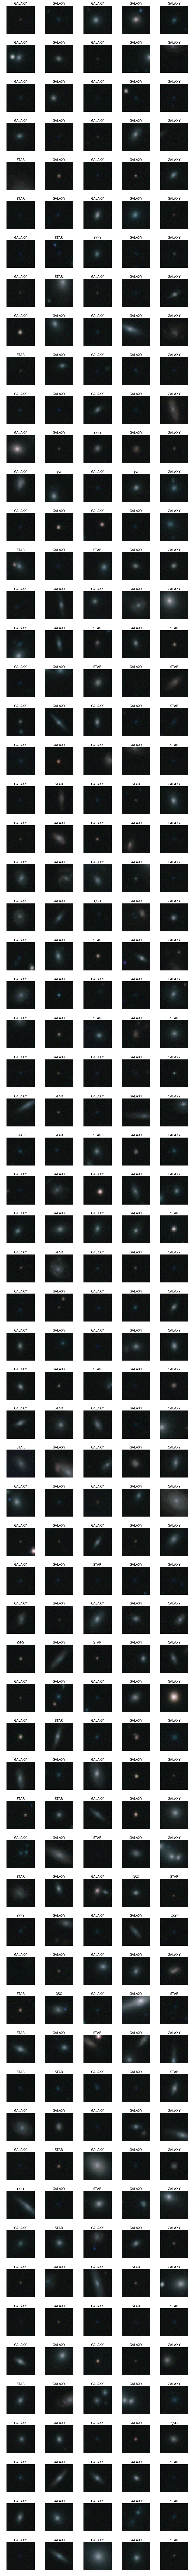

In [20]:
size = 48

cutouts = os.listdir("result")
ncol = 5
nrow = len(cutouts) // 5
np.random.shuffle(cutouts)
cutouts = cutouts[: ncol * nrow]

fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 2))
fig.tight_layout()

rgb = np.zeros((nrow * ncol, size, size, 3))
for i, f in enumerate(cutouts):
    fpath = os.path.join("result", f)
    cutout = np.load(fpath)
    rgb[i, :, :, :] = np.rollaxis(cutout[1:4, :, :], 0, 3) # 1:4 for "gri" in "ugriz"

for j in range(3):
    v = rgb[:, :, :, j]
    rgb[:, :, :, j] = (v - v.min()) / (v.max() - v.min()) * 255

# invert values so that the background is black
rgb = 255 - rgb.astype(np.uint8)

for i, f in enumerate(cutouts):
    row, col = i // ncol, i % ncol
    ax[row, col].imshow(rgb[i, :, :, :], interpolation="nearest")
    ax[row, col].axis("off")
    ax[row, col].set_title(f.split(".")[0])